# 08: DeepONet


**Exercise:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/08-deeponet/08-deeponet-exercise.ipynb)
**Solution:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/08-deeponet/08-deeponet.ipynb)

## Problems with PINNs

We represent a multi-layer perceptron (MLP) $y = \mathbf{\mathcal{F}}(x;\theta)$ as a function that takes an input $x \in Ro^d$ and gives an output $y \in Ro^d$ with trainable weights $\theta$. A Physics Informed Neural Network (PINN) can be described as  $\mathbf{u}(x) = \mathbf{\mathcal{F}}(x;\theta)$ taking as input the independent variable $x$ of the underlying Partial Differential Equation (PDE) and outputs its solution, $\mathbf{u}(x)$.  The training process for a PINN involves minimizing the combined residual of the PDE and its boundary conditions.

To illustrate, consider the PDE

$$
\begin{align*}
\nabla \cdot (\kappa \nabla u) &= f(x), \quad x \in \Omega = [0,1] \times [0,1]\\
  u(x) & = g(x), \quad x \in \partial \Omega
\end{align*}
$$

and train a PINN $\mathcal{F}(x;\theta)$ to minimize the loss function
$$
\Pi(\theta) = \frac{1}{N_v} \sum_{i=1}^{N_v} | \nabla \cdot (\kappa \nabla \mathcal{F}(x_i;\theta)) - f(x_i) |^2 + \frac{\lambda_b}{N_b} \sum_{i=1}^{N_b} | \mathcal{F}(x_i;\theta) - g(x_i) |^2
$$

The optimal weights are given by $\theta^* = \argmin{\theta} \Pi(\theta)$  and the corresponding PINN solution for the above PDE becomes $u(x) =\mathcal{F}(x;\theta^*)$. 

However, if we alter either $f$ or $g$ in the PDE, the previously trained network may no longer be applicable. Essentially, we would need to retrain the network (potentially with the same structure) for the updated $f$ and $g$ values. This repeated training can be inefficient and is something we'd prefer to bypass. In the subsequent sections, we'll explore strategies to address this challenge.


## Parameterized PDE
Consider the source term $f$ in the above PDE is given as a parametric function $f(x;\alpha)$. For instance, we could have

$$
f(x_1,x_2;\alpha) = 4 \alpha x_1 (1-x_1) (1-x_2) 
$$

Then we could train a PINN that accommodates for the parametrization by considering a network that takes as input both $x$ and $\alpha$, i.e., $\mathcal{F}(x, \alpha;\theta)$.

This network can be trained by minimizing the loss function
$$
\Pi(\theta) = \frac{1}{N_a} \sum_{j=1}^{N_a}\left[\frac{1}{N_v} \sum_{i=1}^{N_v} | \nabla \cdot (\kappa \nabla \mathcal{F}(x_i,\alpha_j;\theta)) - f(x_i,\alpha_j) |^2 + \frac{\lambda_b}{N_b} \sum_{i=1}^{N_b} | \mathcal{F}(x_i,\alpha_j;\theta) - g(x_i) |^2 \right]
$$

We have to also consider collocation points for the parameter $\alpha$ while constructing the loss function. If $\theta^* = \argmin{\theta} \Pi(\theta)$, then the solution to the parameterized PDE would be $u(x,\alpha) = \mathcal{F}(x, \alpha;\theta^*) $. Further, for any new value of $\alpha = \hat{\alpha}$ we could find the solution by evaluating $\mathcal{F}(x,\hat{\alpha};\theta^*)$. We could use the same approach if there was a way of parameterizing the functions $\kappa(x)$ and $g(x)$. 

![Parameterized PINNs](parameterized-pinn.png)
> Schematic of a PINN with a parameterized input


However, what if we wanted the solution for an arbitrary, non-parametric $f$?  In order to do this, we need to find a way to approximate **operators that map functions to functions**.

## Functions and Operators:

### Function:

 Maps between vector spaces:

*Example:*

Let $f_1(x)=sin(x)$; for  $x\in\mathbf{R}$

$$z=f_1(x)=sin(x)\in[0:1]$$

In other words $f_1$ maps $\mathbf{R}→[0,1]$

### Operator:

 Maps between infite-dimensional function spaces:
$$G(f_1(x))=f_2(x)$$

*Example:*

Derivative Operator →$\frac{d}{d x}$

It transforms a funcion $f_1$ into a function $f_2$:

Let $f_1(x)=sin(x)$

Then when we apply our operator:

$$f_2=\frac{df_1(x)}{d x}=\frac{d}{d x}sin(x)=cos(x)$$


### Parametric PDEs and Operators

Parametric PDEs $\rightarrow$ Some parameters (e.g., shape, IC/BC, coefficients, etc.) of a given PDE system are allowed to change.

Let  $\mathcal{N}$ be a nonlinear operator. Let's consider a parametric PDEs of the form:

$$\mathcal{N}(u,s)=0$$

Where $u$ is the input function and $s$ is the unknown PDE's solution (also a function).

Our PDE solution operator would be:

$$G(u)=s$$

**Note 1:** In other words, we can express the general solution of our PDE as an operator $G$

**Note 2:** Remember $s$ is itself a function, so if we evaluate it at any point $y$, the answer would be a real number:

 $$G(u)(y)=s(y)\in \mathbf{R}$$


The universal approximation theorem states that neural networks can be used to approximate any continuous function to arbitrary accuracy if no constraint is placed on the width and depth of the hidden layers. However, another approximation result, which is yet more surprising and has not been appreciated so far, states that a neural network with 
a single hidden layer can approximate accurately any nonlinear continuous __functional__ (a mapping from a space of functions into the real numbers) or (nonlinear) operator (a mapping from a space of functions into another space of functions).

Before reviewing the approximation theorem for operators, we introduce some notation, which will be used through this paper. Let $G$ be an operator taking an input function $u$, and then $G(u)$ is the corresponding output function. For any point $y$ in the domain of $G(u)$,  the output $G(u)(y)$ is a real number. Hence, the network takes inputs composed of two parts: $u$ and $y$, and outputs $G(u)(y)$. Although our goal is to learn operators, which take a function as the input, we have to represent the input functions discretely, so that network approximations can be applied. A straightforward and simple way, in practice, is to employ the function values at sufficient but finite many locations $\{x_1, x_2, \dots, x_m\}$; we call these locations as ``sensors''.


## Universal Approximation Theorem for Operator

Suppose that $\sigma$ is a continuous non-polynomial function, $X$ is a Banach Space, $K_1 \subset X$, $K_2 \subset \mathbb{R}^d$ are two compact sets in $X$ and $\mathbb{R}^d$, respectively, $V$ is a compact set in $C(K_1)$, $G$ is a nonlinear continuous operator, which maps $V$ into $C(K_2)$. Then for any $\epsilon>0$, there are positive integers $n$, $p$, $m$, constants $c_i^k, \xi_{ij}^k, \theta_i^k, \zeta_k \in \mathbb{R}$, $w_k \in \mathbb{R}^d$, $x_j \in K_1$, $i=1,\dots,n$, $k=1,\dots,p$, $j=1,\dots,m$, such that
$$
\left|G(u)(y) - \sum_{k=1}^p
\underbrace{\sum_{i=1}^n c_i^k \sigma\left(\sum_{j=1}^m \xi_{ij}^ku(x_j)+\theta_i^k\right)}_{branch}
\underbrace{\sigma(w_k \cdot y+\zeta_k)}_{trunk}
\right|<\epsilon  
$$
holds for all $u \in V$ and $y \in K_2$.

![DeepONet](sensors-deeponet.png)
> Illustrations of the problem setup and architectures of DeepONets.} (**A**) The network to learn an operator $G: u \mapsto G(u)$ takes two inputs $[u(x_1), u(x_2), \dots, u(x_m)]$ and $y$. (**B**) Illustration of the training data. For each input function $u$, we require that we have the same number of evaluations at the same scattered sensors $x_1, x_2, \dots, x_m$. However, we do not enforce any constraints on the number or locations for the evaluation of output functions. (**C**) The stacked DeepONet in Theorem~\ref{thm:main} has one trunk network and $p$ stacked branch networks. (**D**) The unstacked DeepONet has one trunk network and one branch network.

The universal approximation theorem suggests that neural networks have the potential to learn nonlinear operators from data, much like current deep learning techniques. However, while the theorem indicates that fully-connected neural networks (FNNs) can theoretically approximate functions, they often underperform when compared to specialized architectures like convolutional neural networks (CNNs) in practical scenarios. This is primarily because the theorem only addresses approximation errors and neglects the equally critical optimization and generalization errors. For a neural network to be effective, it must not only approximate well but also train efficiently and generalize to new data.

# DeepONet

We focus on learning operators in a more general setting, where the only requirement for the training dataset is the consistency of the sensors $\{x_1, x_2, \dots, x_m\}$ for input functions. In this general setting, the network inputs consist of two separate components:  $[u(x_1), u(x_2), \dots, u(x_m)]^T$ and $y$ (see above Fig A), and the goal is to achieve good performance by designing the network architecture. One straightforward solution is to directly employ a classical network, such as FNN, CNN or RNN, and concatenate two inputs together as the network input, i.e., $[u(x_1), u(x_2), \dots, u(x_m), y]^T$. However, the input does not have any specific structure, and thus it is not meaningful to choose networks like CNN or RNN. Here we use FNN as the baseline model.

In high dimensional problems, $y$ is a vector with $d$ components, so the dimension of $y$ does not match the dimension of $u(x_i)$ for $i=1,2,\dots,m$ any more. This also prevents us from treating $u(x_i)$ and $y$ equally, and thus at least two sub-networks are needed to handle $[u(x_1), u(x_2), \dots, u(x_m)]^T$ and $y$ separately. Although the universal approximation theorem does not have any guarantee on the total error, it still provides us a network structure. The theorem only considers a shallow network with one hidden layer, so we extend it to deep networks, which have more expressivity than shallow ones. The architecture we propose is shown in Fig. C, and the details are as follows. First there is a "trunk" network, which takes $y$ as the input and outputs $[t_1, t_2, \dots, t_p]^T \in \mathbb{R}^p$. In addition to the trunk network, there are $p$ "branch" networks, and each of them takes $[u(x_1), u(x_2), \dots, u(x_m)]^T$ as the input and outputs a scalar $b_k \in \mathbb{R}$ for $k=1,2,\dots,p$. We merge them together as:

$$ G(u)(y) \approx \sum_{k=1}^p b_k t_k. $$

We note that the trunk network also applies activation functions in the last layer, i.e., $t_k = \sigma(\cdot)$ for $k=1,2,\dots,p$, and thus this trunk-branch network can also be seen as a trunk network with each weight in the last layer parameterized by another branch network instead of the classical single variable. We also note that in Eq. \ref{eq:thm} the last layer of each $b_k$ branch network does not have bias. Although bias is not necessary in Theorem \ref{thm:main}, adding bias may increase the performance by reducing the generalization error. In addition to adding bias to the branch networks, we may also add a bias $b_0 \in \mathbb{R}$ in the last stage:

$$
G(u)(y) \approx \sum_{k=1}^p b_k t_k + b_0.
$$

In practice, $p$ is at least of the order of 10, and using lots of branch networks is computationally and memory expensive. Hence, we merge all the branch networks into one single branch network (Fig. D), i.e., a single branch network outputs a vector $[b_1, b_2, \dots, b_p]^T \in \mathbb{R}^p$. When $p$ branch networks stacked parallel it is `stacked DeepONet`, while the other is termed `unstacked DeepONet`.

A standard DeepONet comprises two neural networks. We describe below its construction to approximate an operator $\mathcal{N} : A \rightarrow U$, where $A$ is a set of functions of the form $a: \Omega_X \subset Ro^d \rightarrow Ro$ while $U$ consists of functions of the form $u: \Omega_Y \subset Ro^D \rightarrow Ro$. Furthermore, we assume that point-wise evaluations of both class of functions is possible. The architecture for the DeepONet is explained below:


* Fix $M$ distinct sensor points $x^{(1)},..., x^{(M)}$ in $\Omega_X$.
* Sample a function $a \in A$ at these sensor points to get the vector $\mathbf{a} =  [a(x^{(1)}), ... , \ a(x^{(M)})]^\top \in Ro^M$.

* Supply $\mathbf{a}$ as the input to a sub-network, called the _branch net_ $\mathcal{B}(.;\mathbf{\theta}_B):Ro^M \rightarrow Ro^p$, whose output would be the vector $\mathbf{\beta} = [\beta_1(\mathbf{a}), ..., \ \beta_p(\mathbf{a})]^\top\in Ro^p$. Here $\mathbf{\theta}_B$ are the trainable parameters of the branch net. The dimension of the output of the branch is relatively small, say $p \approx 100$.

* Supply $x$ as an input to a second sub-network, called the _trunk net_ $\mathcal{T}(.;\mathbf{\theta}_T): Ro^D \rightarrow Ro^p$, whose output would be the vector $\mathbf{\tau} = [\tau_1(u), ..., \ \tau_p(u)]^\top \in Ro^p$. Here $\mathbf{\theta}_T$ are the trainable parameters of the trunk net.

* Take a dot product of the outputs of the branch and trunk nets to get the final output of the DeepONet $\widetilde{\mathcal{N}}(.,.;\mathbf{\theta}):Ro^D \times Ro^M \rightarrow Ro$ which will approximate the value of $u(y)$


$u(y) \approx \widetilde{\mathcal{N}}(y,\mathbf{a};\mathbf{\theta}) = \sum_{k=1}^p \beta_k(\mathbf{a}) \tau_k(y).$

where the trainable parameters of the DeepONet will be the combined parameters of the branch and trunk nets, i.e., $\mathbf{\theta} = [\theta_T, \theta_M]$.

![DeepONet](DeepONet.png)
> Schematic of a DeepONet

In the above construction, once the DeepONet is trained (we will discuss the training in the following section), it will approximate the underlying operator $\mathcal{N}$, and allow us to approximate the value of any $\mathcal{N}(a)(y)$ for any $a \in A$ and any $x \in \Omega_Y$. Note that in the construction of the DeepONet, the $M$ sensor points need to be pre-defined and cannot change during the training and evaluation phases.


We can make the following observations regarding the DeepONet architecture:

* The expression in (\ref{eq:deeponet}) has the form of representing the solution as the sum of a series of coefficients and functions. The coefficients are determined by the branch network, while the functions are determined by the trunk network. In that sense the DeepONet construction is similar to that of what is used in the spectral method or the finite element method. There is a critical difference though. In these methods, the basis functions are pre-determined and selected by the user. However, in the DeepONet these functions are determined by the trunk network and their final form depends on the data used to train the DeepONet. 

* Architecture of the branch sub-network: When points for sampling the input function are chosen randomly, the appropriate architecture for the branch network comprises fully connected layers. Further recognizing that the dimension of the input to this network can be rather large $N_1 \approx 10^4$, while the output is typically small $p \approx 10^2$, this network can be thought of as an encoder. 
    
* When points for sampling the input function are chosen on a uniform grid, the appropriate architecture for the branch network comprises convolutional layer layers. In that case this network maps an image of large dimension ($N_1 \approx 10^4$) to a latent vector of small dimension, $p \approx 10^2$. Thus it is best represented by a convolutional neural network.  
    
* Broadly speaking, there are two ways of improving the experssivity of the DeepONet. These involve increase the number of network parameters in the branch and trunk sub-networks, and increasing the dimension $p$ of the latent vectors formed by these sub-networks.

## Training DeepONets
Training a DeepONet is typically supervised, and requires pairwise data. The following are the main steps involved:

* Select $N_1$ representative function $a^{(i)}$, $1 \leq i \leq N_1$ from the set $A$. Evaluate the values of these functions at the $M$ sensor points, i.e., $a^{(i)}_j = a^{(i)}(x^{(j)})$ for $1 \leq j \leq M$. This gives us the vectors $\mathbf{a}^{(i)} = [a^{(i)}(x^{(1)}),...,a^{(i)}(x^{(M)})]^\top \in Ro^M$ for each $1 \leq i \leq N_1$.

* For each $a^{(i)}$, determine (numerically or analytically) the corresponding functions $u^{(i)}$ given by the operator $\mathcal{N}$. 

* Sample the function $u^{(i)}$ at $N_2$ points in $\Omega_Y$, i.e., $u^{(i)}(y^{(k)})$ for $1 \leq k \leq N_2$. 

* Construct the training set 

$$
\mathcal{S} = \left \{\Big(\mathbf{a}^{(i)}, y^{(k)}, u^{(i)}(y^{(k)})\Big) : 1 \leq i \leq N_1, \ 1 \leq k \leq N_2 \right\}
$$

which will have $N_1 \times N_2$ samples.

* Define the loss function

$$
\Pi(\theta) = \frac{1}{N_1 N_2} \sum_{i=1}^{N_1} \sum_{k=1}^{N_2} | \widetilde{N}(y^{(k)}, \mathbf{a}^{(i)};\theta) - u^{(i)}(y^{(k)})|^2.
$$

* Training the DeepONet corresponds to finding $\theta^* = \argmin{\theta} \Pi(\theta)$.

* Once trained, then given any new $a \in A$ samples at the $M$ sensor points (which gives the vector $\mathbf{a} \in Ro^M$), and a new point $y \in \Omega_Y$, we can evaluate the corresponding prediction $u^*(y) = \widetilde{N}(y, \mathbf{a};\theta^*)$. 

> Note:
We need not choose the same $N_2$ points across all $i$ in the training set. In fact, these can be chosen randomly leading to a more diverse dataset.

> Note:
The DeepONet can be easily extended to the case where the input comprises multiple functions. In this case, the trunk network remains the same, however the branch network now has multiple vectors as input. The case corresponding to two input functions, $a(x)$ and $b(x)$, which when sampled yield the vectors, $\mathbf{a}$ and $\mathbf{b}$.

> Note:
The DeepONet can be easily extended to the case where the output comprises multiple functions (say $D$ such functions). In this case, the output of the branch and trunk network leads to $D$ vectors each with dimension $p$. The solution is then obtained by taking the dot product of each one of these vectors.  The case corresponding to two output functions $u_1(y)$ and $u_2(y)$ 

 ### Universal Approximation Theorem for Operator

 $\forall \epsilon >0$, there are positive integers $n,p,m$, constants $c_i^k,W_{bij}^k,b_{bij}^k,W_{tk},b_{tk}$ such that:

$$\left|G(u)(y)-\sum_{k=1}^{p}\sum_{i=1}^{n}c_i^k\sigma\left(\sum_{j=1}^{m}W_{bij}^{k}u(x_j)+b_{bi}^k\right).\sigma(W_{tk}.y+b_{tk})\right|<\epsilon $$

 ### Neural Network

A Neural Network is a function that takes the form:

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2\sigma_1(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

So we can use 2 NNs to implement the Universal Approximation Theorem for Operator i.e.:

Branch:

$$NN_b(u(\textbf{x}))=b(u(\textbf{x}))=\textbf{c}.\sigma\left(W_{b}u(\textbf{x})+\textbf{b}_{b}\right)$$

Trunk:


$$NN_t(\textbf{y})=t(\textbf{y})=\sigma(W_{t}.\textbf{y}+\textbf{b}_{t})$$

### DeepOnet

Learn the solution operators of parametric PDEs → We will try to approximate $G$  (the solution of our PDE operator) by two neural networks:


$$G_\theta(u)(y)=\sum_{k=1}^q\underset{Branch}{\underbrace{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{t_k(\textbf{y})}}$$


We want to obtain G, so our goal would be:

 $$G_\theta(u)(y)\approx G(u)(y)$$

So we will enforce that condition into a loss function:

$$\mathcal{L}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|G_{\theta}(u^{(i)})y_j^{(i)}-G(u^{(i)})y_j^{(i)}\right|^2$$


$$\mathcal{L}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|\sum_{k=1}^q{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}.t_k(y_j^{(i)})-G(u^{(i)})y_j^{(i)}\right|^2$$

where $N$ is the number of functions $u(x)$ in our training dataset, $P$, is the number of points inside the domain at which we will evaluate $G(u)$. 

$m:$ Number of points at which we evaluated our input functions.

$N:$ Number of input functions.

$P:$ Number of points at which we evaluate the output function $\rightarrow$ output sensors.


**In summary:**

To train a DeepOnet, we would:

1.   We select $N$ functions →$u(x)$.
2.   We evaluate our $N$ functions at $m$ points (i.e., input sensors) →$u(x_1),u(x_2),...,u(x_m)$
3.   We send the $m$ outputs of our $N$ functions to our **branch network** → $b_k(u(x_1),u(x_2),...,u(x_m))$
4.   We select $P$ points (i.e., output sensors) inside our domain → $y_1,y_2,...,y_P$
5.  We send our output sensors to our **trunk network**→$t_k(y_1,y_2,...,y_P)$
6. We approximate our operator by computing the dot product between the outpur of our **branch network** and the output of our **trunk network**→ $G_\theta(u)(y)=\sum_{k=1}^q\underset{Branch}{\underbrace{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{t_k(\textbf{y})}}$
7. Ideally $G_\theta(u)(y)\approx G(u)(y)$, so we compute the error → $\mathcal{L}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|G_{\theta}(u^{(i)})y_j^{(i)}-G(u^{(i)})y_j^{(i)}\right|^2$

8. We update our NN parameters (i.e., branch and trunk) to minimize  $\mathcal{L}(\theta)$.
9. We repeat the process.

# Problem Setup

## Anti-derivative Operator

Our PDE would be:

$$\frac{ds(x)}{dx}-u(x)=0$$


The solution of our PDE is:

$$G:u(x)→s(x)=s(0)+\int_{0}^{x}u(t)dt$$

$$x\in[0,1]$$
$$s(0)=0$$

In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

# Data Generation

We will randomly sample 10000 different functions $u$ from a zero-mean Gaussian process with an exponential quadratic kernel with a length scale: $l=0.2$.

In [2]:
N_train = 10000
m = 100 # number of input sensors
P_train = 1   # number of output sensors
length_scale = 0.2 #lenght_scale for the exponential quadratic kernel
key_train = random.PRNGKey(0)  # use different key for generating training data and test data 
config.update("jax_enable_x64", True) # Enable double precision

I0000 00:00:1697459542.060556       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


## Generate a random function

## RBF (Radial Basis Function) Kernel

An RBF kernel, often termed the Gaussian kernel, is a widely-used kernel function in the realms of machine learning and statistics. It finds predominant applications in support vector machines (SVMs) and kernel principal component analysis (PCA).

The mathematical expression for the RBF kernel is:

$$K(\mathbf{x}, \mathbf{y}) = \exp\left(-\frac{||\mathbf{x} - \mathbf{y}||^2}{2\sigma^2}\right)$$

Where:
- $K(\mathbf{x}, \mathbf{y})$ represents the kernel value between data points $\mathbf{x}$ and $\mathbf{y}$.
- $||\mathbf{x} - \mathbf{y}||$ denotes the Euclidean distance separating the two data points.
- $\sigma$ is a freely adjustable parameter, often referred to as the bandwidth or spread of the kernel. The magnitude of $\sigma$ dictates the reach or influence of individual data points when assessing similarity. A diminutive $\sigma$ yields a constricted kernel, implying each point has a restricted zone of influence. Conversely, an enlarged $\sigma$ produces a more expansive kernel, with data points influencing a broader region.

The intrinsic concept behind the RBF kernel is to gauge the similarity between two points in the input space. The function's value peaks (i.e., 1) when both points overlap and diminishes (approaching 0) as the points diverge. The decrement rate is modulated by the $\sigma$ parameter.

The term "radial basis" originates from the kernel's value being contingent solely on the distance (i.e., radially symmetric) between the two points, rather than their absolute coordinates.


In [3]:
# Define RBF kernel
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [4]:
def plot_us(x,u,y,s):
  fig, ax1 = plt.subplots(figsize=(8, 6))
  plt.rcParams['font.size'] = '18'
  color='black'
  wdt=1.5
  ax1.plot(x,u,'k--',label='$u(x)=ds/dx$',linewidth=wdt)
  ax1.plot(y,s,'o-',label='$s(x)=s(0)+\int u(t)dt|_{t=y}$',linewidth=wdt)
  ax1.set_xlabel('x',fontsize='large')
  ax1.set_ylabel('u',fontsize='large')
  ax1.tick_params(axis='y', color=color)
  ax1.legend(loc = 'lower right', ncol=1)

## Sampling from a Gaussian Process

A Gaussian process (GP) provides a distribution over functions. Using a GP, one can draw function samples, make predictions for unseen data, and more. The behavior of the GP is governed by its mean function and covariance (kernel) function.

### 1. Define the Mean and Kernel Function

Given your requirements, the mean function is zero everywhere, and the kernel is the exponential quadratic kernel.

**Mean function**: 
$$ m(x) = 0 $$

**Exponential quadratic kernel**:
$$ k(x, x') = \exp\left(-\frac{(x - x')^2}{2l^2}\right) $$
where $l$ is the length scale and, in this case, $l=0.2$.

### 2. Select Points for Sampling

Before drawing samples from the GP, decide on which input points $x$ you want to evaluate your sampled functions. This could be a grid of points or any other set of interest.

### 3. Compute the Covariance Matrix

For these selected points, compute the covariance matrix $K$ using your kernel function. If you have $n$ points, this matrix will be $n \times n$. Each element $K_{ij}$ of the matrix is computed as:
$$ K_{ij} = k(x_i, x_j) $$

### 4. Sample from the Multivariate Gaussian

With a mean of zero and the covariance matrix $K$ you've computed, you can now draw samples from a multivariate Gaussian distribution. Each sample will give you a realization of the function $u$ over your selected input points.


In [5]:
# Sample GP prior at a fine grid
N = 512
gp_params = (1.0, length_scale)
jitter = 1e-10
# X are the input points ranging between 0 and 1, reshaped to be a column vector.
X = np.linspace(0, 1, N)[:,None]
#  computes the covariance matrix K for the input points X using the Radial Basis Function (RBF) kernel, 
# which is another name for the squared exponential or Gaussian kernel.
K = RBF(X, X, gp_params)
# The Cholesky decomposition is used here to decompose the covariance matrix K. 
# The addition of the jitter term ensures that K is positive definite, which is a requirement for Cholesky decomposition.
L = np.linalg.cholesky(K + jitter*np.eye(N))
# Using the Cholesky factor L and a vector of random normal numbers, 
# this line produces a sample from the Gaussian Process. The shape of this sample is (N,).
gp_sample = np.dot(L, random.normal(key_train, (N,)))

# Create a callable interpolation function  
# This lambda function u_fn is a simple 1D interpolation function. Given a value t, 
# it returns the interpolated value of gp_sample at that point using the values in X as reference.
u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)
# Input sensor locations and measurements
x = np.linspace(0, 1, m)
u = vmap(u_fn, in_axes=(None,0))(0.0, x) #vectorize our code to run it in multiple batches simultaneusly (or to evaluate a function simultaneusly)

We obtain the corresponding 10000 ODE solutions by solving: 

$$\frac{ds(x)}{dx}=u(x)$$

Using an explicit Runge-Kutta method(RK45)→ JAX's odeint functiom.

In [6]:
# Output sensor locations and measurements
y_train = random.uniform(key_train, (P_train*100,)).sort() 
s_train = odeint(u_fn, 0.0, y_train) # Obtain the ODE solution

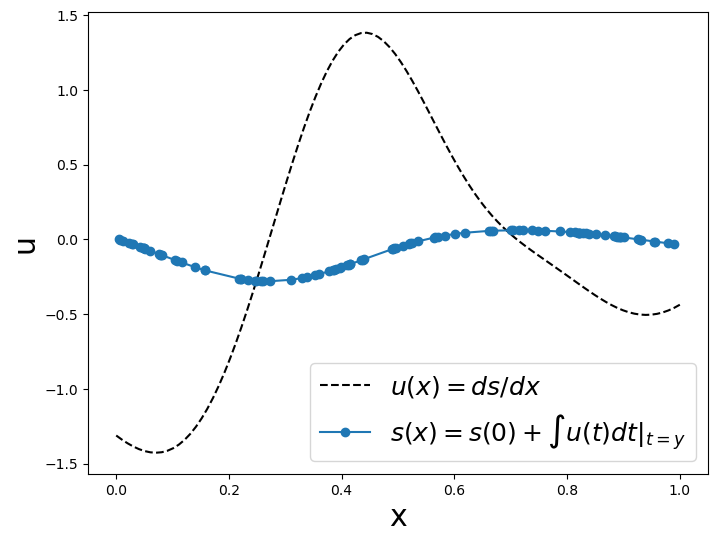

In [7]:
plot_us(x,u,y_train,s_train)

Now, we will have to create many functions for our testing and training dataset, so let's create a pair of programing-functions to generate one random function at a time.

## Data Generation for DeepONet

DeepONet is a deep learning model tailored for operator regression tasks. This document summarizes the process for generating training data for DeepONet.

### 1. Sampling Gaussian Process (GP)

We begin by generating function samples:

- **Function Samples**: 10,000 functions, $u$, are drawn from a zero-mean Gaussian process.
- **Kernel Specification**: The kernel of the GP is an exponential quadratic kernel with a length scale given by:
  $ l = 0.2 $

### 2. Fine Grid Sampling

A more detailed sampling procedure is applied:

- **Grid Points**: A set of 512 points is chosen, uniformly spaced between 0 and 1.
- **Kernel Calculation**: Using the Radial Basis Function (RBF) kernel (equivalent to the squared exponential kernel), we compute the covariance matrix, $K$, for these grid points.
- **Cholesky Decomposition**: This method is applied to the matrix $K$ to yield samples from the GP.

## 3. Interpolation

An interpolation mechanism is constructed:

- **Interpolation Function**: An interpolation function, `u_fn`, is formed. Given an input $t$, it provides the interpolated value from the GP sample at that position.

### 4. Input Sensors

Details about the input sensors:

- **Sensor Count**: We utilize 100 evenly distributed sensors, ranging from 0 to 1.
- **GP Values**: These function values at the sensor locations act as our inputs, denoted by `u`.

### 5. ODE Solutions

The differential equation to be solved is:

$$ \frac{ds(x)}{dx} = u(x) $$

- **Methodology**: The equation is resolved with JAX's `odeint` function, leveraging the explicit Runge-Kutta method (RK45).

### 6. Output Sensors

Details about the output sensors:

- **Output Locations**: `y_train` indicates the output sensor locations, which are ascertained at random. The number of these sensors is `P_train`, which is set to 1.
- **ODE Solution**: The ODE's solution is determined at these specific sensor locations.

### 7. Data Generation Function

To optimize the data generation:

- **Function Creation**: The `generate_one_training_data` function is defined, producing training data for one single input sample.
- **Purpose**: This function encapsulates the GP sampling, interpolation, sensor placements, and ODE solutions, facilitating reproducibility and scalability for generating multiple training samples.

In [8]:
# Geneate training data corresponding to one input sample
def generate_one_training_data(key, m=100, P=1):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = np.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y_train = random.uniform(key, (P,)).sort() 
    s_train = odeint(u_fn, 0.0, np.hstack((0.0, y_train)))[1:] # JAX has a bug and always returns s(0), so add a dummy entry to y and return s[1:]

    # Tile inputs
    u_train = np.tile(u, (P,1))

    return u_train, y_train, s_train


In [9]:
# Geneate test data corresponding to one input sample
def generate_one_test_data(key, m=100, P=100):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = np.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y = np.linspace(0, 1, P)
    s = odeint(u_fn, 0.0, y)

    # Tile inputs
    u = np.tile(u, (P,1))

    return u, y, s 

## Data Generation

In [10]:
# Training Data
N_train = 10000 #Number of functions
m = 100 # number of input sensors
P_train = 1   # number of output sensors
key_train = random.PRNGKey(0)  # use different key for generating training data and test data 

In [11]:
config.update("jax_enable_x64", True) # Enable double precision
keys = random.split(key_train, N_train) # Obtain 10000 random numbers

In [12]:
gen_fn = jit(lambda key: generate_one_training_data(key, m, P_train)) #lets call our function
u_train, y_train, s_train = vmap(gen_fn)(keys)

In [13]:
# Reshape the data
u_train = np.float32(u_train.reshape(N_train * P_train,-1))
y_train = np.float32(y_train.reshape(N_train * P_train,-1))
s_train = np.float32(s_train.reshape(N_train * P_train,-1))

In [14]:
# Testing Data
N_test = 1 # number of input samples 
P_test = m   # number of sensors 
key_test = random.PRNGKey(12345) # A different key 

In [15]:
keys = random.split(key_test, N_test)
gen_fn = jit(lambda key: generate_one_test_data(key, m, P_test))
u, y, s = vmap(gen_fn)(keys)

In [16]:
#Reshape the data
u_test = np.float32(u.reshape(N_test * P_test,-1))
y_test = np.float32(y.reshape(N_test * P_test,-1))
s_test = np.float32(s.reshape(N_test * P_test,-1))

In [17]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements, BC/IC conditions, etc.)
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

# DeepOnet

In [18]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [19]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=relu)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=relu)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=1000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()
        # Logger
        self.loss_log = []

    # Define opeartor net
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs
      
    # Define ODE/PDE residual
    def residual_net(self, params, u, y):
        s_y = grad(self.operator_net, argnums = 2)(params, u, y)
        return s_y

    # Define loss
    def loss(self, params, batch):
        # Fetch data
        # inputs: (u, y), shape = (N, m), (N,1)
        # outputs: s, shape = (N,1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute loss
                loss_value = self.loss(params, batch)

                # Store loss
                self.loss_log.append(loss_value)

                # Print loss during training
                pbar.set_postfix({'Loss': loss_value})
       
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_s_y(self, params, U_star, Y_star):
        s_y_pred = vmap(self.residual_net, (None, 0, 0))(params, U_star, Y_star)
        return s_y_pred

# Evaluate our Operator

In [20]:
# Initialize model
# For vanilla DeepONet, shallower network yields better accuarcy.
branch_layers = [100, 100, 100] 
trunk_layers =  [1, 100, 100]

model = DeepONet(branch_layers, trunk_layers)

In [21]:
# Create data set
batch_size = 10000
dataset = DataGenerator(u_train, y_train, s_train, batch_size)

In [22]:
# Train
model.train(dataset, nIter=40000)


100%|██████████| 40000/40000 [19:46<00:00, 33.71it/s, Loss=4.915084494012098e-07] 


In [23]:
# Predict
params = model.get_params(model.opt_state)

In [24]:
s_pred = model.predict_s(params, u_test, y_test)[:,None]

In [25]:
s_y_pred = model.predict_s_y(params, u_test, y_test) # remember that s_y=ds/dy=u

In [26]:
# Compute relative l2 error
error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 
error_u = np.linalg.norm(u_test[::P_test].flatten()[:,None] - s_y_pred) / np.linalg.norm(u_test[::P_test].flatten()[:,None]) 

In [27]:
print(error_s,error_u)

0.0021329330534194317 0.084637


## Visualize the results for the first function in our Testing Dataset

In [28]:
idx=0
index = np.arange(idx * P_test,(idx + 1) * P_test)

error_u: 2.133e-03
error_s: 8.464e-02


/var/folders/6k/lmrc2s553fq0vn7c57__f37r0000gn/T/ipykernel_9180/93944556.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


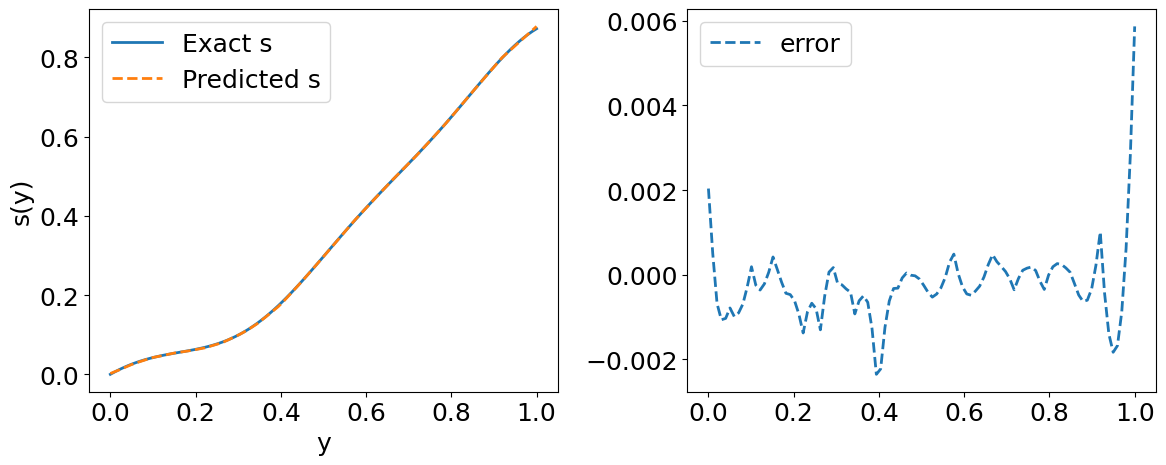

/var/folders/6k/lmrc2s553fq0vn7c57__f37r0000gn/T/ipykernel_9180/93944556.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


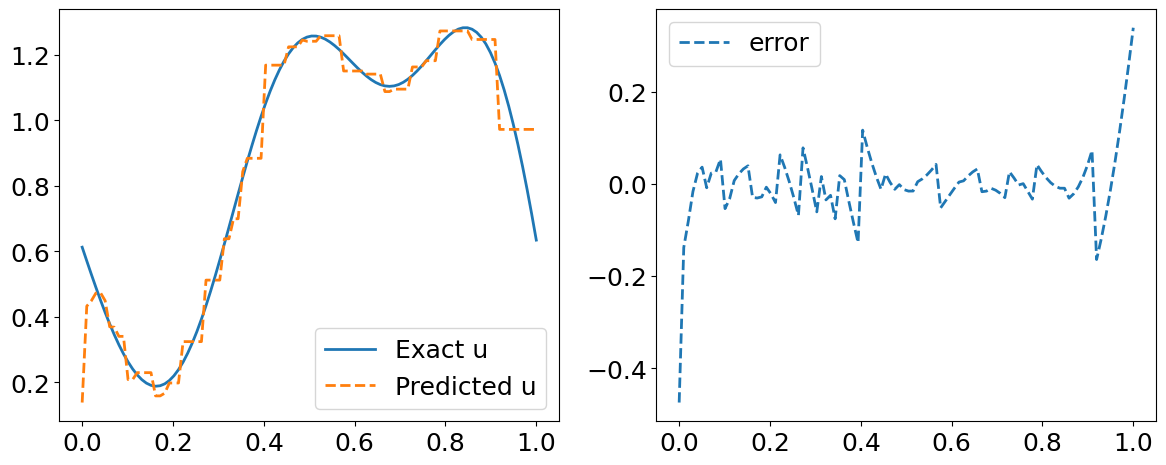

In [29]:
# Compute the relative l2 error for one input sample 
error_u = np.linalg.norm(s_test[index, :] - s_pred[index, :], 2) / np.linalg.norm(s_test[index, :], 2) 
error_s = np.linalg.norm(u_test[::P_test][idx].flatten()[:,None] - s_y_pred[index, :], 2) / np.linalg.norm(u_test[::P_test][idx].flatten()[:,None], 2) 

print("error_u: {:.3e}".format(error_u))
print("error_s: {:.3e}".format(error_s))

# Visualizations
# Predicted solution s(y)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], s_test[index, :], label='Exact s', lw=2)
plt.plot(y_test[index, :], s_pred[index, :], '--', label='Predicted s', lw=2)
plt.xlabel('y')
plt.ylabel('s(y)')
plt.tight_layout()
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_pred[index, :] - s_test[index, :], '--', lw=2, label='error')
plt.tight_layout()
plt.legend()
plt.show()

# Predicted residual u(x)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], u_test[::P_test][idx], label='Exact u', lw=2)
plt.plot(y_test[index, :], s_y_pred[index,:], '--', label='Predicted u', lw=2)
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_y_pred[index,:].flatten() - u_test[::P_test][idx] , '--', label='error', lw=2)
plt.legend()
plt.tight_layout()
plt.show()

# Example

Lets obtain the anti-derivative of a trigonometric function. **However**, remember that this neural operator works for $x\in[0,1]$ when the antiderivative's initial value ($s(0)=0$). To fulfill that conditions, we will use $u(x)=cos(2\pi x),∀x\in[0,1]$.


So, we will evaluate our operator ($G$):


$$G:u(x)→s(x)=s(0)+\int_{0}^{x}u(t)dt$$

to $u(t)=cos(2\pi t)$:

$$s(x)=s(0)+\int_{0}^{x}cos(2\pi t)dt$$

Since $s(0)=0$, the answer would be (the integral of u):

$$s(x)=\frac{1}{2\pi}sin(2\pi x)$$



In [30]:
#u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)
u_fn = lambda t, x: -np.cos(2*np.pi*x)
# Input sensor locations and measurements
x = np.linspace(0, 1, m)
u = u_fn(None,x)
# Output sensor locations and measurements
y =random.uniform(key_train, (m,)).sort()

In [31]:
# reshapte the data to be processed by our DeepOnet
u2=np.tile(u,100)
u2=np.float32(u2.reshape(N_test * P_test,-1))
y=y.reshape(len(y),1)

In [32]:
s=model.predict_s(params, u2, y)[:,None]

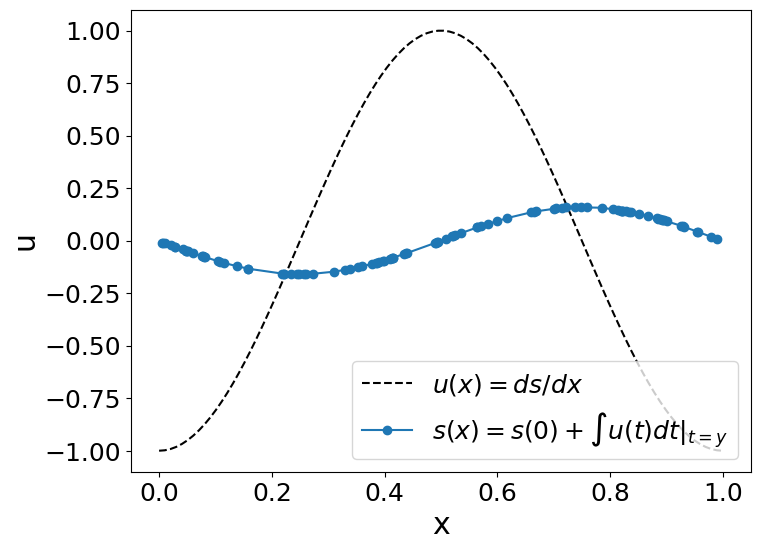

In [33]:
plot_us(x,u,y,s)

# References

[1] Lu, L., Jin, P., & Karniadakis, G. E. (2019). Deeponet: Learning nonlinear operators for identifying differential equations based on the universal approximation theorem of operators. arXiv preprint arXiv:1910.03193.

[2] Wang, S., Wang, H., & Perdikaris, P. (2021). Learning the solution operator of parametric partial differential equations with physics-informed DeepONets. Science advances, 7(40), eabi8605.

[3] Ray, D., Pinti, O., & Oberai, A. A. (2023). Deep Learning and Computational Physics (Lecture Notes). arXiv preprint arXiv:2301.00942.